# Cash Flow Waterfall Model: PSC Economic Limit Calculator
**Author:** Ade Anggi Naluriawan Santoso | **Project:** Probabilistic Simulation and Cash Flow

## 1. Introduction & Objectives
This notebook implements a **Production Sharing Contract (PSC)** economic model to evaluate the commercial viability of an oil & gas asset.

### Problem Statement
In a PSC regime, the revenue flow is non-linear. Gross revenue is first used to recover costs (Cost Recovery), and the remaining "Profit Oil" is split between the Government and the Contractor. The Contractor is then taxed on their share. The complexity lies in determining **when** the cost of operating exceeds the Contractor's share of revenue—this point is the **Economic Limit**.

### Objectives
1.  **Calculate Gross Revenue:** Based on production profiles and price forecasts.
2.  **Model the Fiscal Regime:** Implement the "Waterfall" logic (Revenue $\to$ Cost Recovery $\to$ Profit Split $\to$ Tax).
3.  **Determine Net Cash Flow (NCF):** Calculate the final cash available to the Contractor.
4.  **Identify Economic Limit:** The year when `Contractor NCF <= 0`.

### Key Assumptions (Standard PSC)
* **Cost Recovery Cap:** 100% (All revenue is available to recover costs immediately).
* **Profit Split:** 85% Government / 15% Contractor.
* **Corporate Tax Rate:** 40%.
* **First Tranche Petroleum (FTP):** 0% (Simplified for this exercise).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration for prettier plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries loaded successfully.")

Libraries loaded successfully.


## 2. Load and Inspect Data
We load the production, price, and cost profiles from our CSV file.

In [2]:
# Load the dataset
df = pd.read_csv('project_economics_data.csv')

# Display the first few rows
df.head()

,Year,Oil_Prod_bbl,Gas_Prod_mmbtu,Oil_Price_USD_bbl,Gas_Price_USD_mmbtu,OPEX_Fixed_USD,OPEX_Var_USD_bbl,CAPEX_USD
0,2024,1500000,500000,75,4.5,12000000,8,50000000
1,2025,1350000,450000,72,4.5,12000000,8,10000000
2,2026,1215000,405000,70,4.2,12000000,8,5000000
3,2027,1093500,364500,68,4.0,12000000,9,2000000
4,2028,984150,328050,65,4.0,12500000,9,2000000


## 3. Calculation Step 1: Gross Revenue
The first step in the waterfall is calculating the total money generated by the asset before any deductions.

**Formula:**
$$Gross\ Revenue = (Q_{oil} \times P_{oil}) + (Q_{gas} \times P_{gas})$$

Where:
* $Q$: Production Volume (bbl or mmbtu)
* $P$: Price ($/bbl or $/mmbtu)

In [3]:
# Calculate individual revenues
df['Rev_Oil'] = df['Oil_Prod_bbl'] * df['Oil_Price_USD_bbl']
df['Rev_Gas'] = df['Gas_Prod_mmbtu'] * df['Gas_Price_USD_mmbtu']

# Total Gross Revenue
df['Gross_Revenue'] = df['Rev_Oil'] + df['Rev_Gas']

## 4. Calculation Step 2: Total Expenditures
We must aggregate all cash outflows required to run the project. These are categorized into two main types for accounting purposes:

1.  **OPEX (Operating Expenditure):** Recurrent costs to maintain production (e.g., labor, chemicals, electricity).
    * *Fixed OPEX:* Costs that do not change with production volume.
    * *Variable OPEX:* Costs that scale with volume ($/bbl).
2.  **CAPEX (Capital Expenditure):** One-time investments for drilling, facilities, or major upgrades.

**Formula:**
$$Total\ Cost = (OPEX_{fixed} + OPEX_{variable} \times Q_{oil}) + CAPEX$$

In [4]:
# Calculate Total OPEX
df['Total_OPEX'] = df['OPEX_Fixed_USD'] + (df['OPEX_Var_USD_bbl'] * df['Oil_Prod_bbl'])

# Total Expenditure for the year
df['Total_Cost'] = df['Total_OPEX'] + df['CAPEX_USD']

## 5. Calculation Step 3: Fiscal Regime (The Waterfall)
This is the core logic of the Production Sharing Contract. We calculate how revenue is distributed step-by-step.

### The Waterfall Logic:
1.  **Gross Revenue:** Total income.
2.  **First Tranche Petroleum (FTP):** (Optional) A fixed percentage of revenue taken by the government "off the top" before cost recovery. *We assume 0% here.*
3.  **Cost Recovery:** The Contractor is allowed to take revenue to reimburse their OPEX and CAPEX.
    * *Constraint:* Cost Recovery cannot exceed the Revenue Available (or a specific Cap).
4.  **Profit Oil:** The revenue remaining after costs have been recovered.
    $$Profit\ Oil = Gross\ Revenue - Cost\ Recovery - FTP$$
5.  **Contractor Entitlement:** The Contractor's share of the Profit Oil based on the agreed split (e.g., 15%).
6.  **Taxable Income:** Generally defined as the Contractor's Profit Share + Cost Recovery - Operating Costs. In a simplified model, this equals the Contractor's Profit Share.
7.  **Net Cash Flow (NCF):** The final cash retained by the Contractor.

**NCF Formula:**
$$NCF_{Contractor} = (Cost\ Recovery + Profit\ Share_{Contractor}) - (OPEX + CAPEX) - Tax$$

In [5]:
# --- Fiscal Parameters ---
FTP_PERCENT = 0.00         # First Tranche Petroleum (Assume 0 for simple case)
COST_REC_CAP = 1.00        # 100% of revenue available for cost recovery
GOV_SPLIT = 0.85           # Government Share of Profit Oil
CTR_SPLIT = 1.0 - GOV_SPLIT # Contractor Share (0.15)
TAX_RATE = 0.40            # Corporate Tax Rate

# 1. First Tranche Petroleum (FTP) - Off the top for Gov
df['FTP'] = df['Gross_Revenue'] * FTP_PERCENT
df['Rev_Available_for_Cost'] = df['Gross_Revenue'] - df['FTP']

# 2. Cost Recovery Calculation
# We can only recover costs up to the Revenue Available or the Total Cost, whichever is lower.
df['Cost_Recovery'] = df[['Rev_Available_for_Cost', 'Total_Cost']].min(axis=1)

# 3. Profit Oil Calculation
df['Profit_Oil'] = df['Gross_Revenue'] - df['Cost_Recovery'] - df['FTP']

# 4. Contractor Entitlement (Share of Profit Oil)
df['Contractor_Share_Profit'] = df['Profit_Oil'] * CTR_SPLIT

# 5. Contractor Taxable Income
# Simplified: Taxable Income = Contractor Profit Share (assuming costs are expensed immediately for simplicity)
df['Taxable_Income'] = df['Contractor_Share_Profit']
df['Tax_Payment'] = df['Taxable_Income'] * TAX_RATE

# 6. Contractor Net Cash Flow (NCF)
# Cash In: Cost Recovery + Contractor Share of Profit
# Cash Out: OPEX + CAPEX + Tax
df['Contractor_NCF'] = (df['Cost_Recovery'] + df['Contractor_Share_Profit']) - \
                       (df['Total_OPEX'] + df['CAPEX_USD']) - \
                       df['Tax_Payment']

# Cumulative Cash Flow
df['Cumulative_NCF'] = df['Contractor_NCF'].cumsum()

## 6. Economic Limit Analysis
The **Economic Limit** is the precise point in time when the asset is no longer profitable to operate.

In a PSC, this is **not** simply when `Revenue < Costs`. It is when the **Contractor's Net Cash Flow** turns negative. Due to the fiscal regime (taxes and splits), the Economic Limit often occurs earlier than the physical limit of the reservoir.

* **Condition:** `Contractor_NCF > 0` (Keep Operating)
* **Result:** We will identify the last year where this condition holds true.

In [6]:
# Create a flag for positive cash flow
df['Is_Profitable'] = df['Contractor_NCF'] > 0

# Find the last profitable year
try:
    economic_limit_year = df[df['Is_Profitable']]['Year'].max()
    print(f"✅ Economic Limit Reached in Year: {economic_limit_year}")
except:
    print("⚠️ Project is never profitable or always profitable in this range.")

# Filter DataFrame to show years around the limit
display_cols = ['Year', 'Gross_Revenue', 'Total_Cost', 'Contractor_NCF', 'Cumulative_NCF', 'Is_Profitable']
df[display_cols].style.format({
    'Gross_Revenue': '${:,.0f}',
    'Total_Cost': '${:,.0f}',
    'Contractor_NCF': '${:,.0f}',
    'Cumulative_NCF': '${:,.0f}'
}).background_gradient(subset=['Contractor_NCF'], cmap='RdYlGn')

✅ Economic Limit Reached in Year: 2038


,Year,Gross_Revenue,Total_Cost,Contractor_NCF,Cumulative_NCF,Is_Profitable
0,2024,"$114,750,000","$74,000,000","$3,667,500","$3,667,500",True
1,2025,"$99,225,000","$32,800,000","$5,978,250","$9,645,750",True
2,2026,"$86,751,000","$26,720,000","$5,402,790","$15,048,540",True
3,2027,"$75,816,000","$23,841,500","$4,677,705","$19,726,245",True
4,2028,"$65,281,950","$23,357,350","$3,773,214","$23,499,459",True
5,2029,"$58,753,755","$21,471,615","$3,355,393","$26,854,852",True
6,2030,"$52,878,345","$21,471,610","$2,826,606","$29,681,458",True
7,2031,"$47,590,517","$20,674,450","$2,422,446","$32,103,904",True
8,2032,"$42,831,432","$19,957,000","$2,058,699","$34,162,603",True
9,2033,"$38,548,290","$19,892,430","$1,679,027","$35,841,630",True


## 7. Visualization: Cash Flow Waterfall
To visualize the "Value Erosion," we sum the total lifecycle values (2024–2038) and plot them as a waterfall chart. This highlights how the massive Gross Revenue is whittled down by costs, government take, and taxes, leaving the final Net Cash Flow (Blue bar).

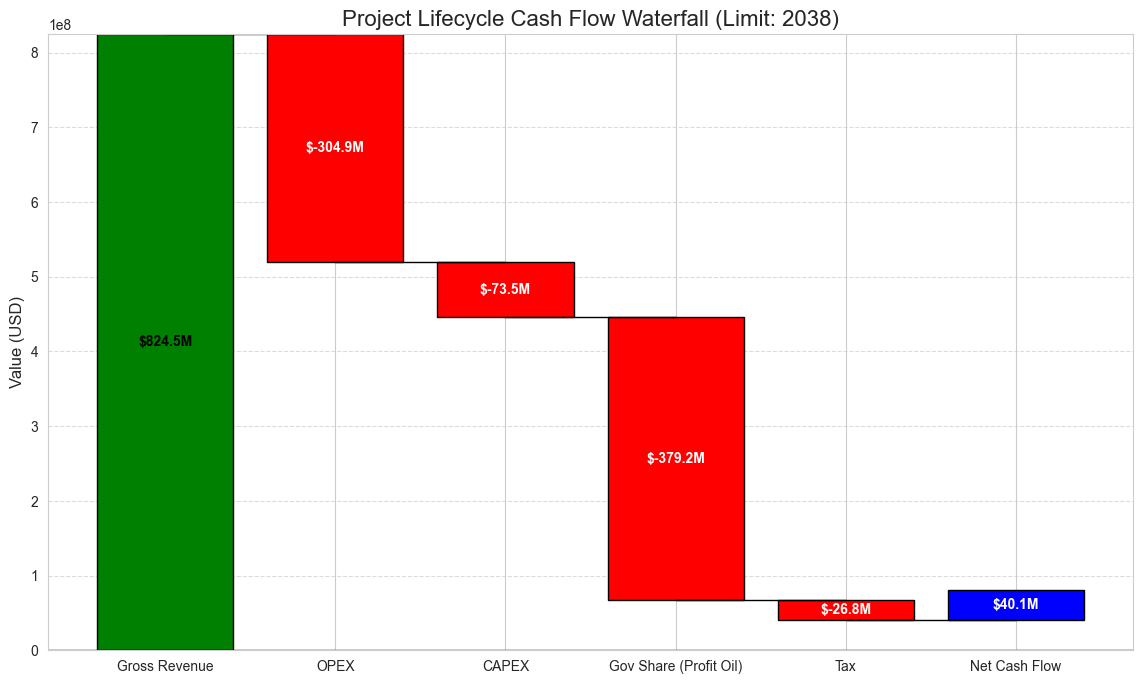

In [7]:
# Summing up the lifecycle totals
total_gross_rev = df['Gross_Revenue'].sum()
total_opex = df['Total_OPEX'].sum()
total_capex = df['CAPEX_USD'].sum()
total_gov_share = (df['Profit_Oil'] * GOV_SPLIT).sum() + df['FTP'].sum()
total_tax = df['Tax_Payment'].sum()
total_ctr_ncf = df['Contractor_NCF'].sum()

# Prepare Data for Waterfall Chart
components = ['Gross Revenue', 'OPEX', 'CAPEX', 'Gov Share (Profit Oil)', 'Tax', 'Net Cash Flow']
values = [total_gross_rev, -total_opex, -total_capex, -total_gov_share, -total_tax, total_ctr_ncf]
colors = ['green', 'red', 'red', 'red', 'red', 'blue']

# Logic for "step" plotting
cumulative = np.cumsum([0] + values[:-1]) # Start points for bars

plt.figure(figsize=(14, 8))

for i in range(len(components)):
    plt.bar(components[i], values[i], bottom=cumulative[i], color=colors[i], edgecolor='black')
    
    # Add labels
    y_pos = cumulative[i] + values[i]/2
    plt.text(i, y_pos, f"${values[i]/1e6:,.1f}M", ha='center', va='center', 
             color='white' if colors[i] != 'green' else 'black', fontweight='bold')

plt.title(f"Project Lifecycle Cash Flow Waterfall (Limit: {economic_limit_year})", fontsize=16)
plt.ylabel("Value (USD)", fontsize=12)
plt.axhline(0, color='black', linewidth=1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Connector lines
for i in range(len(components)-1):
    plt.plot([i, i+1], [cumulative[i+1], cumulative[i+1]], color='black', linewidth=1)

plt.show()

## 8. Visualization: Production vs NCF
Visualizing the decline in production against the cash flow to visually confirm the economic limit.

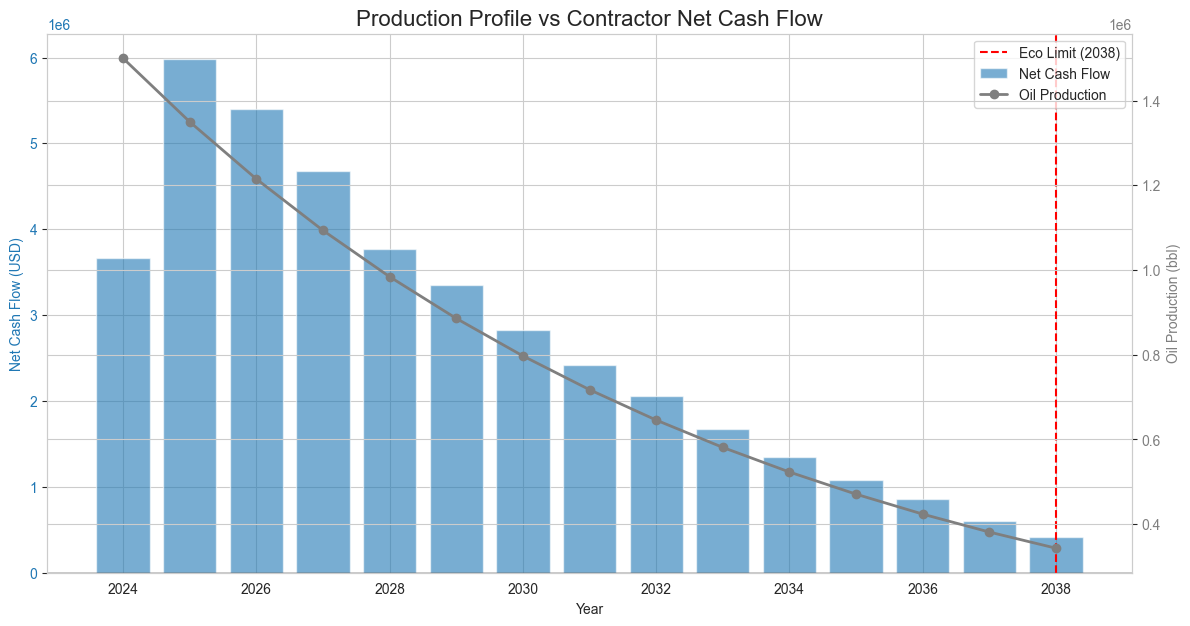

In [8]:
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot Net Cash Flow (Bars)
color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Net Cash Flow (USD)', color=color)
bars = ax1.bar(df['Year'], df['Contractor_NCF'], color=color, alpha=0.6, label='Net Cash Flow')
ax1.tick_params(axis='y', labelcolor=color)
ax1.axhline(0, color='black', linewidth=1)

# Highlight Economic Limit
if economic_limit_year:
    ax1.axvline(economic_limit_year, color='red', linestyle='--', label=f'Eco Limit ({economic_limit_year})')

# Create a second y-axis for Production
ax2 = ax1.twinx()  
color = 'tab:grey'
ax2.set_ylabel('Oil Production (bbl)', color=color)  
line = ax2.plot(df['Year'], df['Oil_Prod_bbl'], color=color, marker='o', linestyle='-', linewidth=2, label='Oil Production')
ax2.tick_params(axis='y', labelcolor=color)

# Combined legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title('Production Profile vs Contractor Net Cash Flow', fontsize=16)
plt.show()